In [38]:
# Importations
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
import yfinance as yf

In [39]:
# Définition des tickers des entreprises
tickers = ["^FCHI","AAPL", "GOOGL", "MSFT", "AMZN", "META"]

# Téléchargement des données historiques des prix de clôture
prices = yf.download(tickers, start="2002-01-01", end="2023-01-01")['Close']

print(prices)

[*********************100%%**********************]  6 of 6 completed


Ticker            AAPL       AMZN      GOOGL        META        MSFT  \
Date                                                                   
2002-01-02    0.416071   0.548000        NaN         NaN   33.520000   
2002-01-03    0.421071   0.595000        NaN         NaN   34.615002   
2002-01-04    0.423036   0.612500        NaN         NaN   34.450001   
2002-01-07    0.408929   0.617000        NaN         NaN   34.279999   
2002-01-08    0.403750   0.592500        NaN         NaN   34.689999   
...                ...        ...        ...         ...         ...   
2022-12-23  131.860001  85.250000  89.230003  118.040001  238.729996   
2022-12-27  130.029999  83.040001  87.389999  116.879997  236.960007   
2022-12-28  126.040001  81.820000  86.019997  115.620003  234.529999   
2022-12-29  129.610001  84.180000  88.449997  120.260002  241.009995   
2022-12-30  129.929993  84.000000  88.230003  120.339996  239.820007   

Ticker            ^FCHI  
Date                     
2002-01-02 

In [40]:
## Calculs des mesures utiles
# Calcul des rendements logarithmiques quotidiens
log_returns = np.log(prices / prices.shift(1))

# Taux sans risque (ex: taux de bons du Trésor Francais à 10 ans)
annual_risk_free_rate = 0.03  # 3%
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/250) - 1

In [41]:
# Simulation parameters
num_simulations = 100000
num_days = 250  # Days in a year for daily simulations
initial_stock_prices = prices.iloc[-1]  # We take the last available price as the initial price
volatility = log_returns.std() * np.sqrt(num_days)  # Annualized volatility from the log returns
risk_free_rate = 0.03
mus = {}
sigmas = {}
# Suppression des NaN
clean_log_returns = log_returns.dropna()

# Calculate mu and sigma for each ticker
for ticker in log_returns.columns:
    mu, sigma = norm.fit(log_returns[ticker].dropna())  # Drop NaN values for accurate fitting
    mus[ticker] = mu
    sigmas[ticker] = sigma

# Display the calculated mu and sigma for each ticker
print("Mean (mu) for each ticker:", mus)
print("Standard Deviation (sigma) for each ticker:", sigmas)

# Calculate the daily risk-free rate
daily_risk_free_rate = np.exp(risk_free_rate / num_days) - 1

# Generate the equity basket simulations
basket_simulations = np.zeros((num_simulations, num_days + 1))
basket_simulations[:, 0] = np.sum(initial_stock_prices)

# Initialize a numpy array to hold the stock price simulations
stock_price_simulations = np.zeros((len(tickers), num_simulations, num_days + 1))
for i, ticker in enumerate(tickers):
    # Set the initial stock prices
    stock_price_simulations[i, :, 0] = initial_stock_prices[ticker]
    # Simulate the stock price for each day
    for day in range(1, num_days + 1):
        daily_stock_returns = np.random.normal(mus[ticker], sigmas[ticker], num_simulations)
        stock_price_simulations[i, :, day] = stock_price_simulations[i, :, day - 1] * (1 + daily_stock_returns)



Mean (mu) for each ticker: {'AAPL': 0.0010510622930868473, 'AMZN': 0.0008381259831725872, 'GOOGL': 0.0007054871929786635, 'META': 0.0004411635870160352, 'MSFT': 0.0004001939708091178, '^FCHI': 4.478205119878155e-05}
Standard Deviation (sigma) for each ticker: {'AAPL': 0.021740089979063036, 'AMZN': 0.02573728569980593, 'GOOGL': 0.019290499179270806, 'META': 0.02549032334888288, 'MSFT': 0.01779175025317905, '^FCHI': 0.014103939515742465}


In [42]:
# Initialize a numpy array to hold the final stock prices
final_stock_prices = np.zeros((len(tickers), num_simulations))

# Populate the final stock prices array
for i, ticker in enumerate(tickers):
    final_stock_prices[i] = stock_price_simulations[i, :, -1]

# Convert the final stock prices array to a DataFrame for easy visualization
final_prices_df = pd.DataFrame(final_stock_prices.T, columns=tickers)

# Display the DataFrame
print("Final stock prices:")
print(final_prices_df)

Final stock prices:
             ^FCHI        AAPL       GOOGL        MSFT        AMZN        META
0      5820.069456  134.966230   86.341310  148.131962  146.158370  216.990579
1      8606.873461  200.610687  155.001177  341.006357   84.257479  278.180921
2      8891.862916  142.294563  167.591790  307.429313   67.845821  186.370289
3      6107.530852  161.964029  126.407649  388.748994   59.859177  153.716210
4      8870.857394  142.268996   76.497886  164.858200   92.078549  105.559058
...            ...         ...         ...         ...         ...         ...
99995  6152.915768  189.098334   50.316018  257.342149  103.092243  121.840998
99996  6374.026336  144.532349  144.675084  289.091756  151.406966  115.207515
99997  7758.319795  152.555686  166.563373  190.952010   75.303505  163.273682
99998  5944.996555  179.076562  137.418680  172.854642   61.993273  121.992786
99999  8210.809027  201.498890   91.589122  228.395537  113.004357  133.660919

[100000 rows x 6 columns]


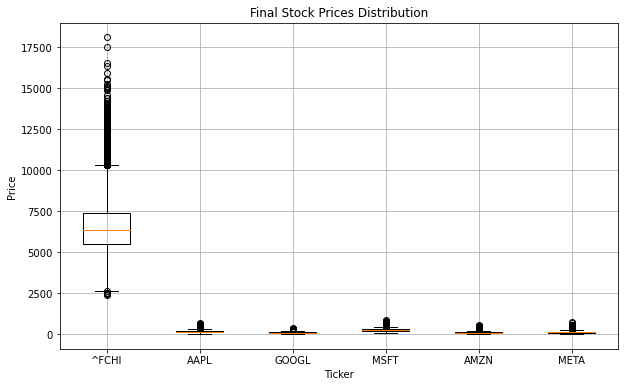

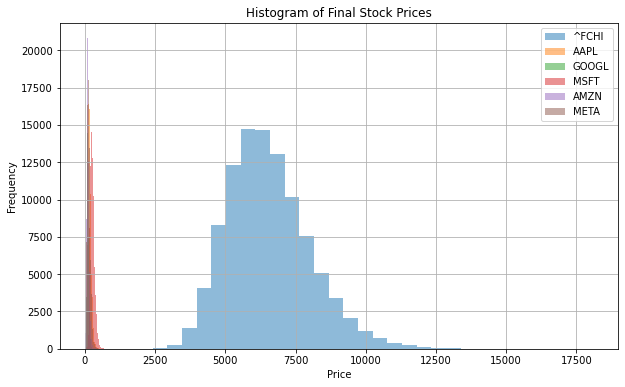

In [43]:
import matplotlib.pyplot as plt

# Plot boxplots for final stock prices
plt.figure(figsize=(10, 6))
plt.boxplot(final_stock_prices.T, labels=tickers)
plt.title('Final Stock Prices Distribution')
plt.xlabel('Ticker')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot histograms for final stock prices
plt.figure(figsize=(10, 6))
for i, ticker in enumerate(tickers):
    plt.hist(final_stock_prices[i], bins=30, alpha=0.5, label=ticker)
plt.title('Histogram of Final Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Calculate the mean final stock price for each ticker
mean_final_prices = final_prices_df.mean()

# Create a DataFrame to hold the initial and mean final stock prices
summary_df = pd.DataFrame({
    'Initial Price': initial_stock_prices,
    'Mean Final Price': mean_final_prices
})

# Display the summary DataFrame
print("Summary of Initial and Mean Final Stock Prices:")
print(summary_df)

Summary of Initial and Mean Final Stock Prices:
       Initial Price  Mean Final Price
AAPL      129.929993        169.283566
AMZN       84.000000        103.502702
GOOGL      88.230003        105.111905
META      120.339996        134.148968
MSFT      239.820007        264.884121
^FCHI    6473.759766       6541.632432
